In [5]:
import torch
from torch import ones, zeros, tensor, eye

from torch.distributions import Categorical

import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

from IPython.display import set_matplotlib_formats
set_matplotlib_formats('retina')
sns.set(style='white', palette='colorblind', color_codes=True, font_scale=1.5)
%matplotlib inline

import sys
import os

import os
cwd = os.getcwd()

sys.path.append(cwd[:-len('befit/examples/control_dilemmas')])

from befit.simulate import Simulator
from befit.tasks import bandits
from befit.agents import AIBandits, Random

from setup_environment import *  # load relevant parameters, like the number of options, segments, trials, etc.

In [6]:
# Define environment
context = torch.from_numpy(np.load('context_{}.npy'.format(blocks)))
offers = torch.from_numpy(np.load('offers_{}.npy'.format(blocks)))

envs = []
for i in range(3):
    envs.append(bandits.MultiArmedBandit(priors, 
                                         transitions, 
                                         context,
                                         offers,
                                         arm_types,
                                         nsub=nsub, 
                                         blocks=blocks, 
                                         trials=trials))

#### Define agents ###

# initial likelihood prior
a = 2*torch.stack([torch.eye(nf), torch.eye(nf)]).reshape(-1, 3)[arm_types] + 1
a = a.repeat(nsub, 1, 1, 1)

nd = 20
pars = {
    'nd': nd,
    'ns': na,  # number of arms
    'na': na,  # number of choices
    'nc': 6,  # number of contexts
    'nf': nf, # number of features
    'ni': 1,  # internal states
}

Bdd = zeros(nd, nd)
d = torch.arange(1., nd + 1.)
beta = .2
Bdd[0] = (-d * beta).softmax(-1)
Bdd[range(1, nd), range(nd-1)] = 1.

Bccd = zeros(nd, 6, 6)
Bccd[0] = (ones(6, 6) - eye(6))/5
Bccd[1:] = eye(6).repeat(nd-1, 1, 1)

tm_higher = {
    'context': Bccd,
    'duration': Bdd
}

efe_agent = AIBandits(pars, 
                      runs=nsub, 
                      blocks=blocks, 
                      trials=trials, 
                      tm={'higher':tm_higher})
efe_agent.set_parameters(x = [a], depth=trials)

iv_agent = AIBandits(pars, 
                     runs=nsub, 
                     blocks=blocks, 
                     trials=trials, 
                     tm={'higher':tm_higher})
iv_agent.set_parameters(x = [a], depth=trials, epistemic=False)

random_agent = Random(pars, runs=nsub, blocks=blocks, trials=trials)

In [7]:
agents = [efe_agent, iv_agent, random_agent]

sim = Simulator(envs, agents, runs=nsub, blocks=blocks, trials=trials)
sim.simulate_experiment()

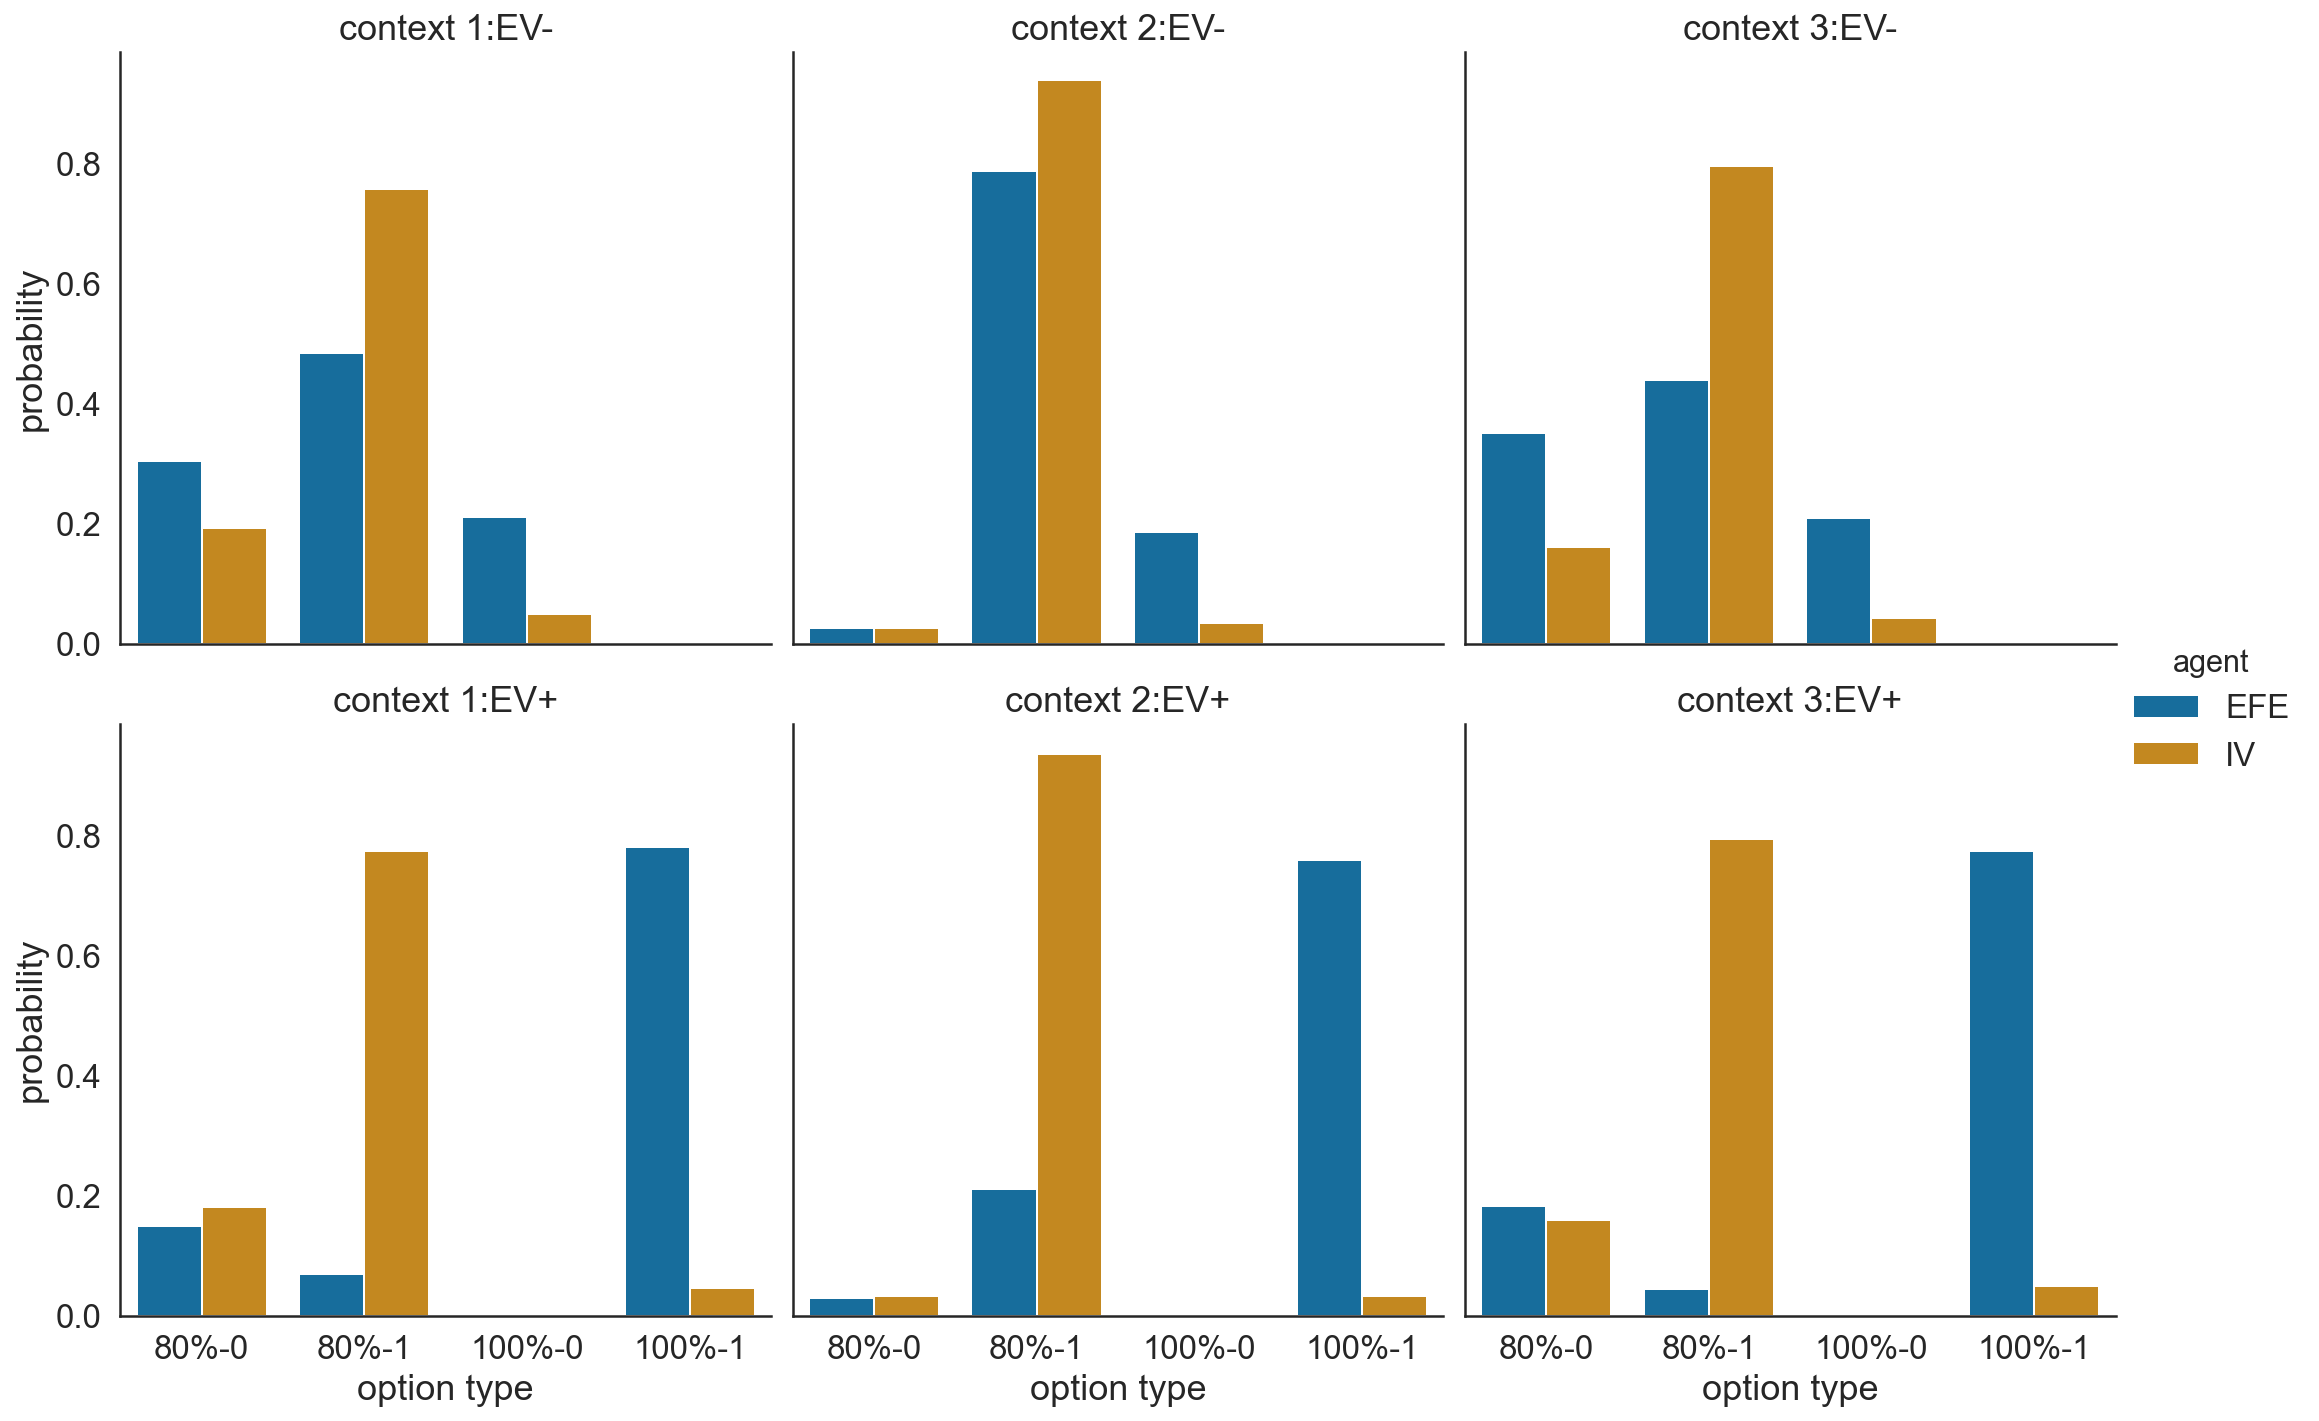

In [14]:
import pandas as pd

cut = 100
offs = offers[cut:, 0]

ctxt = [1, 1, 2, 2, 3, 3]
tp = ['A', 'B', 'A', 'B', 'A', 'B']
name = ['EFE', 'IV']
labels = np.array(['80%-0', '80%-1', '100%-0', '100%-1'])
groups = torch.tensor([0, 1, 1, 2, 3, 3])

dfs = pd.DataFrame()
for i in range(2):
    responses = []
    for res in sim.responses['pair_{}'.format(i)]:
        responses.append(torch.stack(res[1:]))

    responses = torch.stack(responses[cut:])
    choices = arm_types[:, responses].transpose(dim0=-1, dim1=-2)

    for o in range(no):
        loc = o == offs
        vals, count = np.unique(groups[choices[o, loc]], return_counts=True)
        df = pd.DataFrame({'option type': labels[vals], 
                           'probability': count/count.sum(), 
                           'context': ctxt[o], 
                           'variant': tp[o],
                           'agent': name[i]})
        dfs = dfs.append(df, ignore_index=True)
            
g = sns.catplot(x='option type', y='probability', data=dfs, col='context', 
                row='variant', hue='agent', kind="bar")

titles = ['context 1:EV-', 'context 2:EV-', 'context 3:EV-', 'context 1:EV+', 'context 2:EV+', 'context 3:EV+']
for i, ax in enumerate(g.axes.flatten()):
    ax.set_title(titles[i])

plt.savefig('Fig4.png', bbox_inches='tight', transparent=True, dpi=300)

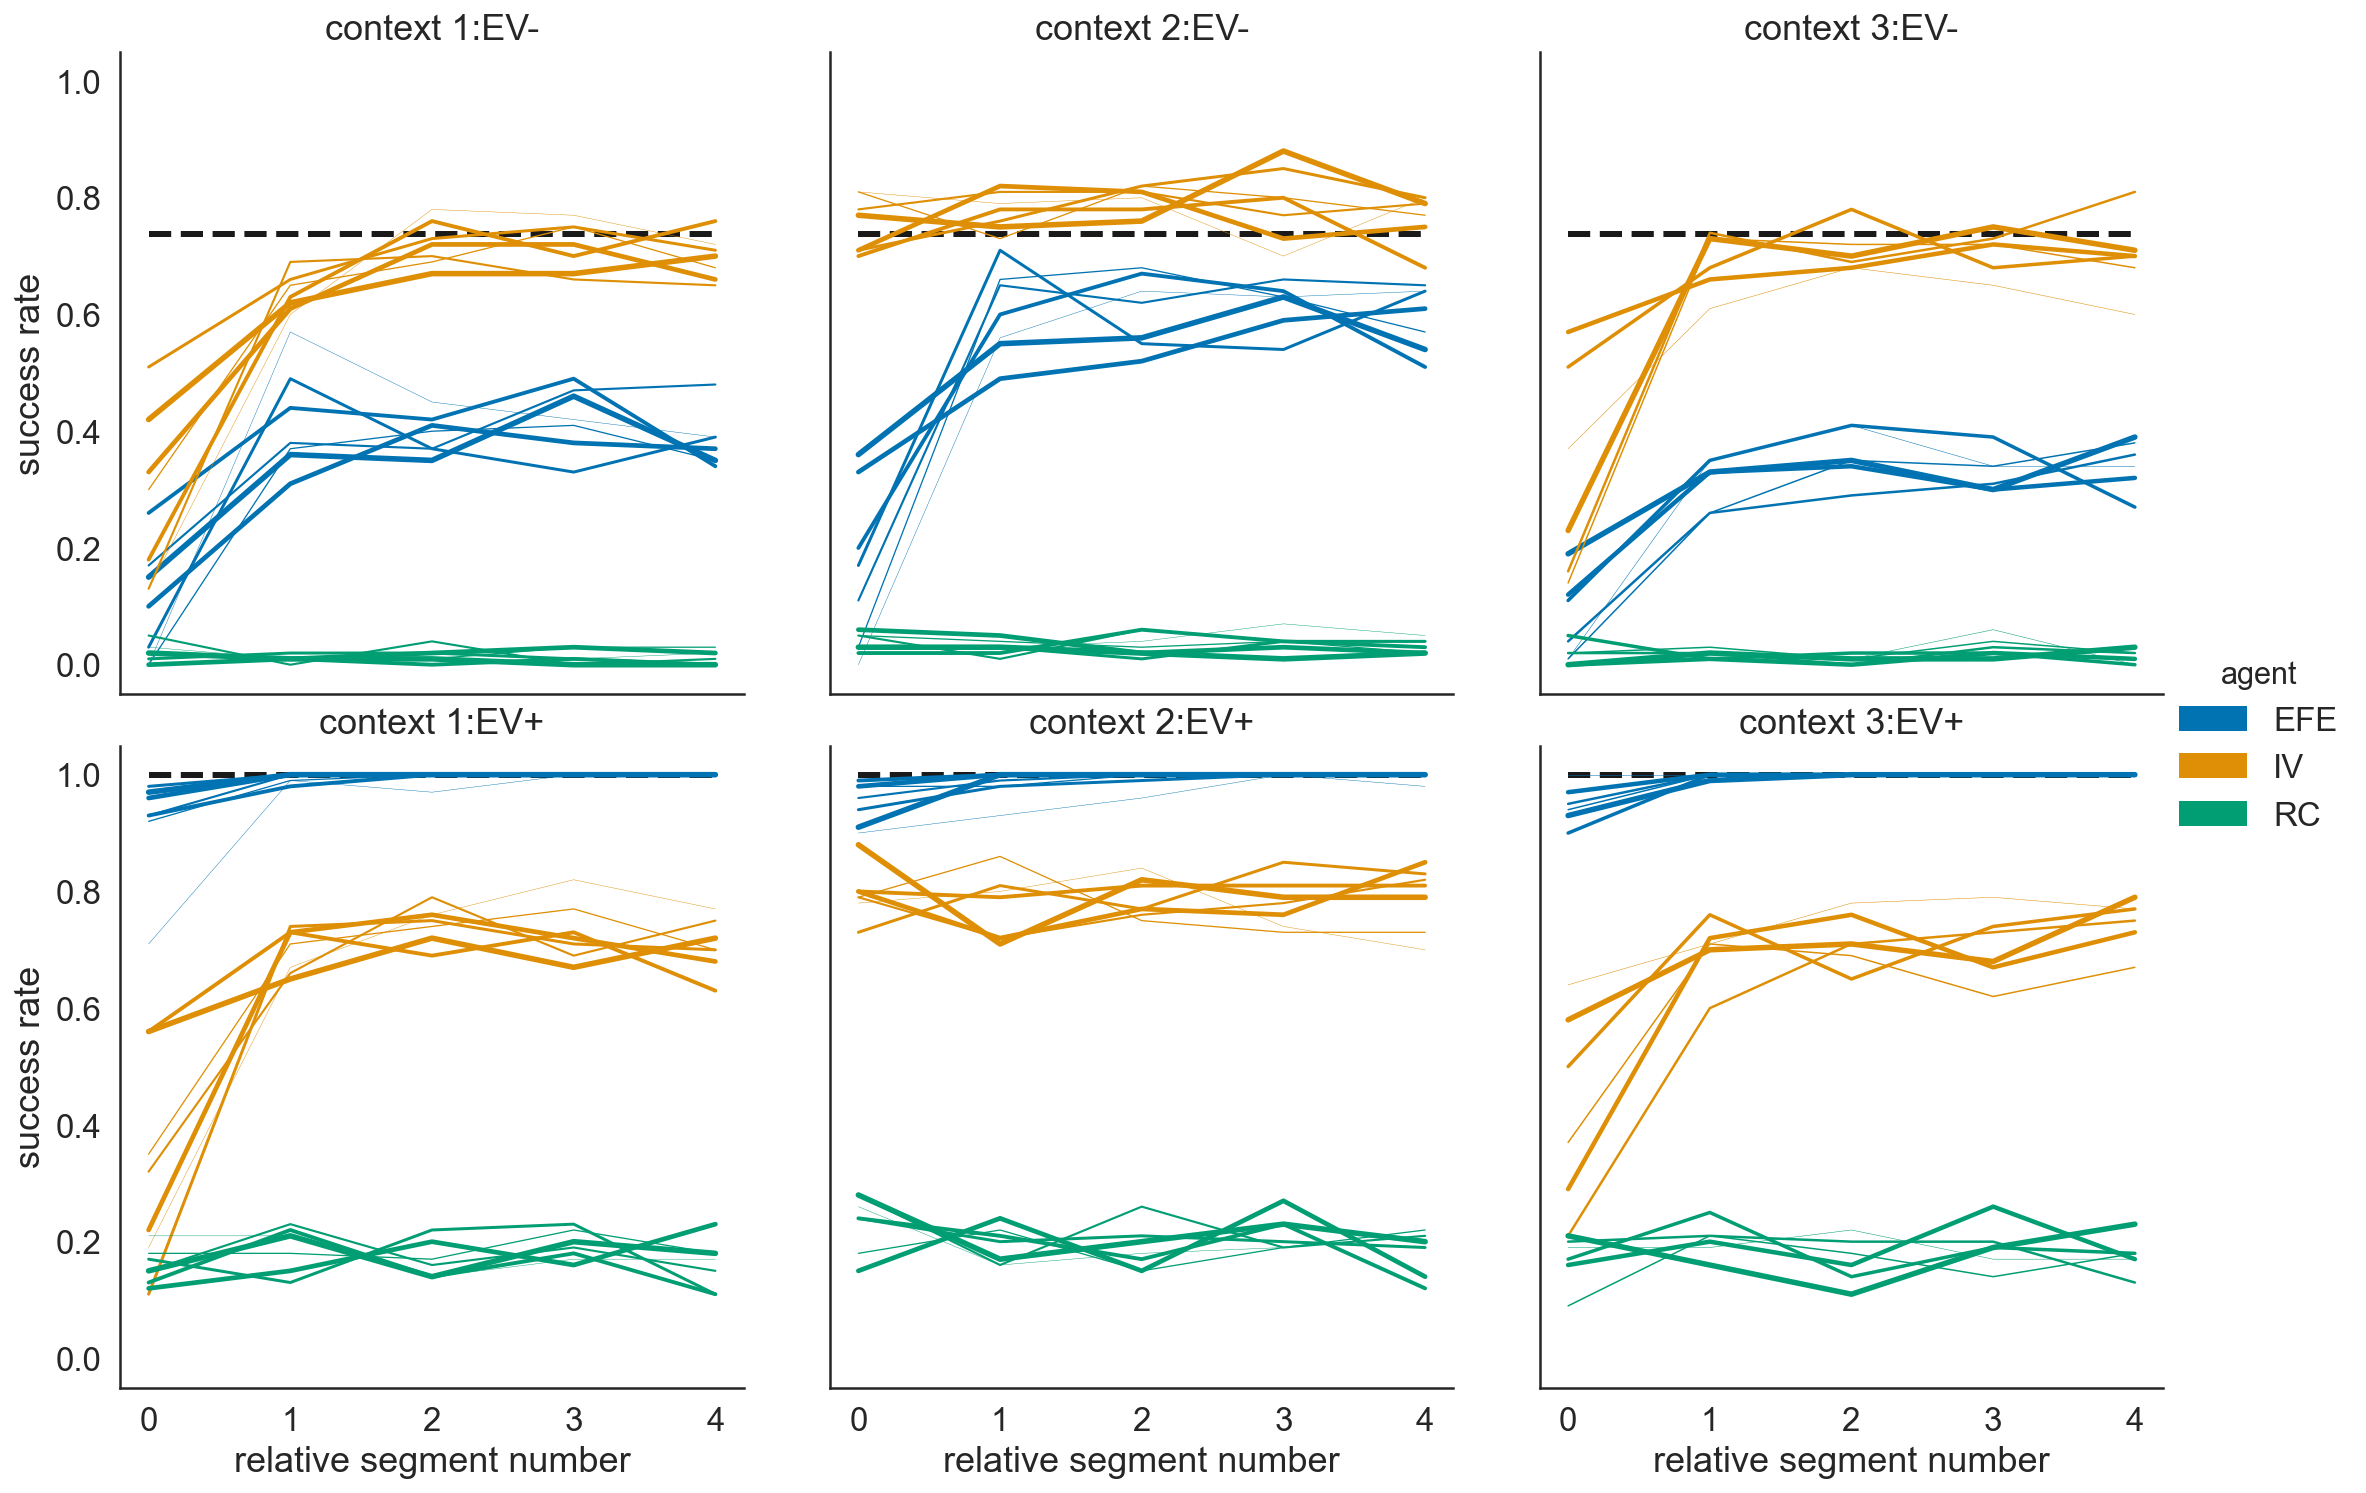

In [13]:
successes = []

out = []
for i in range(3):
    out.append(sim.stimuli['pair_{}'.format(i)]['outcomes'])

for out1, out2, out3 in zip(*out):
    successes.append(torch.stack([out1[-1][-1], 
                                  out2[-1][-1], 
                                  out3[-1][-1]],
                                  -1))
    
successes = torch.stack(successes).float()

g = sns.FacetGrid(dfs, col='context', row='variant', height=5)
for i in range(2):
    g.axes[i, 0].set_ylabel('success rate')
for j in range(3):
    g.axes[-1, j].set_xlabel('relative segment number')

axes = g.axes.flatten()
colors = sns.color_palette(palette='colorblind')[:3]
labels = ['EFE', 'IV', 'RC']
for c, vc in enumerate([0, 2, 4, 1, 3, 5]):
    loc = offers[:, 0, 0] == vc
    sccs = successes[loc].reshape(-1, 5, nsub, 3).mean(-2)
    K = sccs.shape[0]
    lws = np.arange(3/(2*K), 3, 3/K)
    axes[c].set_title(titles[c])
    if c < 3:
        axes[c].hlines(0.73728, 0, 4, 'k', linestyle='--', lw=3)
    else:
        axes[c].hlines(1., 0, 4, 'k', linestyle='--', lw=3)
        
    for i in range(3):
        for j, lw in enumerate(lws):
            if c == 0 and j == len(lws) - 1:
                label = labels[i]
            else:
                label = None
                
            axes[c].plot(sccs[j, ..., i].numpy().T, c=colors[i], lw=lw);
            
import matplotlib as mpl

legend_data = {}
for i in range(3):
    legend_data[labels[i]] = mpl.patches.Patch(color=colors[i], linewidth=1)
g.add_legend(legend_data, title='agent', label_order=labels)

g.fig.savefig('Fig3.png', bbox_inches='tight', dpi=300)

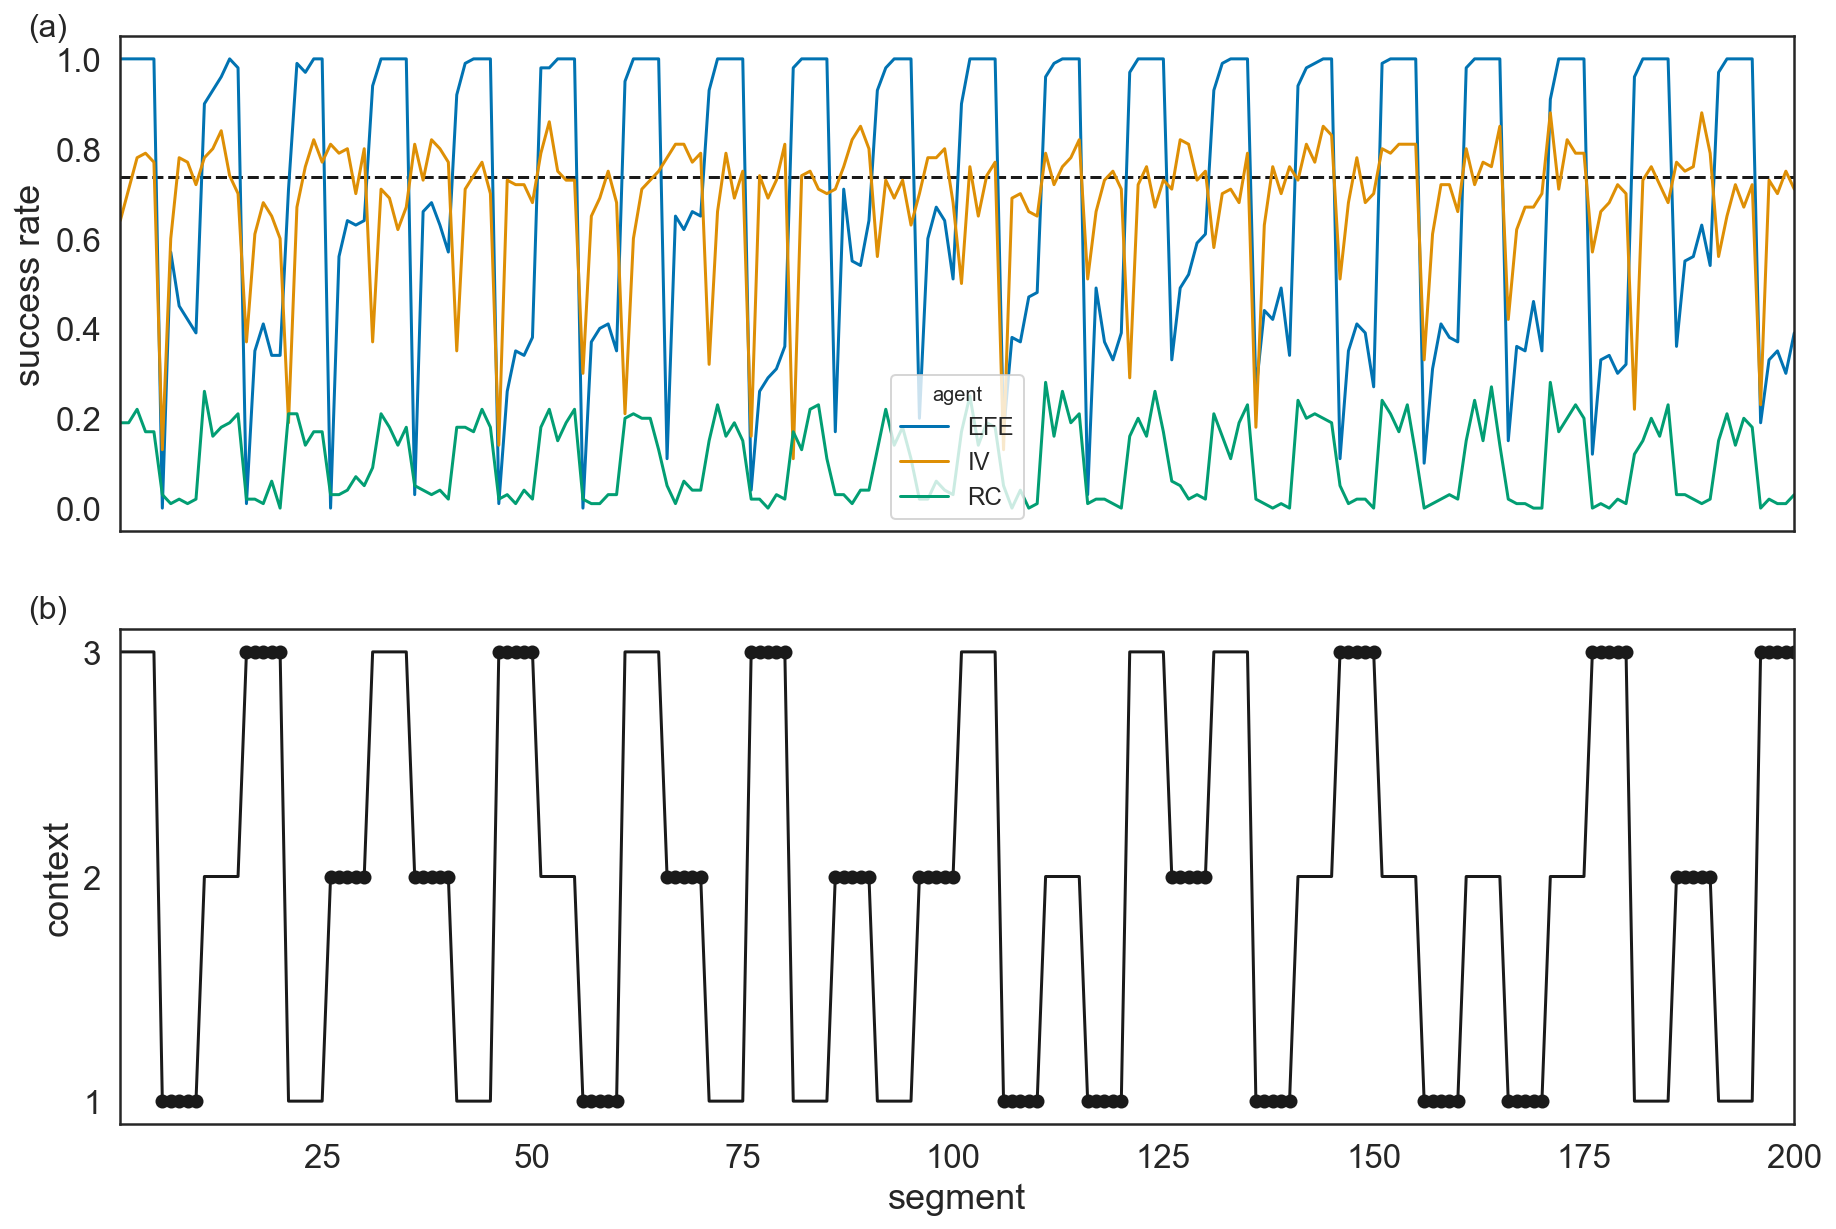

In [10]:
successes = []

out = []
for i in range(3):
    out.append(sim.stimuli['pair_{}'.format(i)]['outcomes'])

for out1, out2, out3 in zip(*out):
    successes.append(torch.stack([out1[-1][-1], 
                                  out2[-1][-1], 
                                  out3[-1][-1]],
                                  -1))
    
successes = torch.stack(successes).float()

maximum = rho**trials + rho**(trials - 1)*(1-rho)*trials

N = nsub//3
colors = sns.color_palette(palette='colorblind')[:3]
fig, axes = plt.subplots(2, 1, figsize=(15, 10), sharex=True)
blks = torch.arange(1, blocks + 1).numpy()
axes[0].plot(blks, successes[..., -3].mean(-1).numpy(), label='EFE');
axes[0].plot(blks, successes[..., -2].mean(-1).numpy(), label='IV');
axes[0].plot(blks, successes[..., -1].mean(-1).numpy(), label='RC');

axes[0].hlines(maximum, 1, blocks, 'k', linestyle='--')
axes[0].set_ylabel('success rate')
axes[0].legend(loc=8, title='agent', fontsize=12)

offs = offers[:,0,0]
offs = ((offs == 0) + (offs == 4) + (offs == 2)).float()
locs = offs == 1

axes[1].plot(blks, context + 1, 'k');
axes[1].plot(blks[locs], context[locs] + 1, 'ko')
axes[1].set_ylabel('context')
axes[1].set_yticks([1, 2, 3])
axes[1].set_xlabel('segment')

axes[0].text(-10, 1.05, '(a)', fontsize=16)
axes[1].text(-10, 3.15, '(b)', fontsize=16)

plt.xlim([1, blocks]);

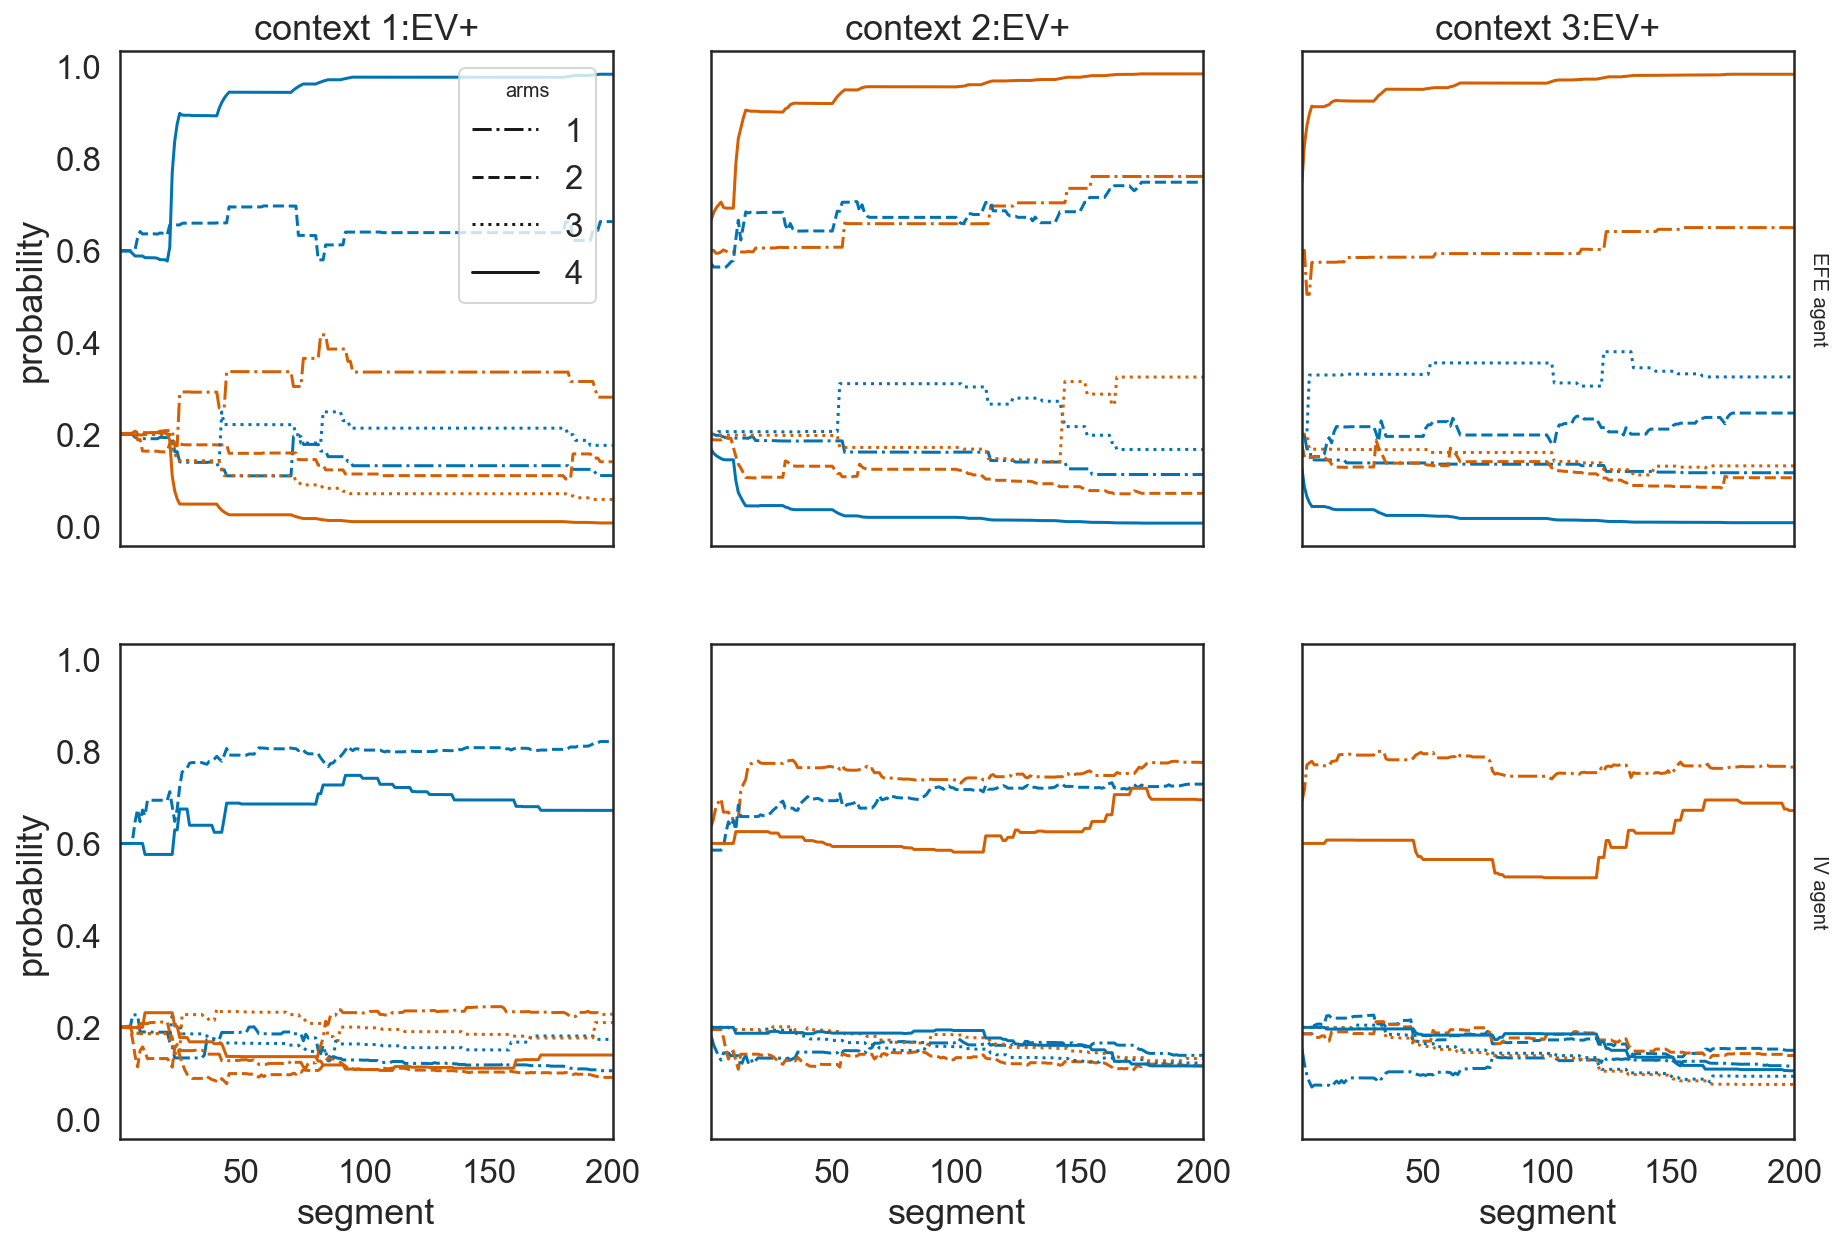

In [16]:
import matplotlib.lines as lns

styles = [lns.Line2D([], [], color='k', linestyle='-.', label='1'),
          lns.Line2D([], [], color='k', linestyle='--', label='2'),
          lns.Line2D([], [], color='k', linestyle=':', label='3'), 
          lns.Line2D([], [], color='k', label='4')]

fig, axes = plt.subplots(2, 3, figsize=(15, 10), sharex=True, sharey=True)

sub = 1
a1 = torch.stack(efe_agent.a)[1:].reshape(blocks, trials, nsub, 6, 4, nf)
A1 = a1/a1.sum(-1, keepdim=True)

a2 = torch.stack(iv_agent.a)[1:].reshape(blocks, trials, nsub, 6, 4, nf)
A2 = a2/a2.sum(-1, keepdim=True)

t = np.arange(1, blocks+1)

for i,c in enumerate([1, 3, 5]):
    axes[0, i].plot(t, A1[:, -1, sub, c, 0, 1].numpy(), 'b-.');
    axes[0, i].plot(t, A1[:, -1, sub, c, 0, 2].numpy(), 'r-.');
    axes[0, i].plot(t, A1[:, -1, sub, c, 1, 1].numpy(), 'b--');
    axes[0, i].plot(t, A1[:, -1, sub, c, 1, 2].numpy(), 'r--');
    axes[0, i].plot(t, A1[:, -1, sub, c, 2, 1].numpy(), 'b:');
    axes[0, i].plot(t, A1[:, -1, sub, c, 2, 2].numpy(), 'r:');
    axes[0, i].plot(t, A1[:, -1, sub, c, 3, 1].numpy(), 'b');
    axes[0, i].plot(t, A1[:, -1, sub, c, 3, 2].numpy(), 'r');
    axes[0, i].set_title('context {}:EV+'.format(i+1));
    
    a = torch.stack(iv_agent.a)[1:].reshape(blocks, trials, nsub, 6, 4, nf)
    A = a/a.sum(-1, keepdim=True)

    axes[1, i].plot(t, A2[:, -1, sub, c, 0, 1].numpy(), 'b-.');
    axes[1, i].plot(t, A2[:, -1, sub, c, 0, 2].numpy(), 'r-.');
    axes[1, i].plot(t, A2[:, -1, sub, c, 1, 1].numpy(), 'b--');
    axes[1, i].plot(t, A2[:, -1, sub, c, 1, 2].numpy(), 'r--');
    axes[1, i].plot(t, A2[:, -1, sub, c, 2, 1].numpy(), 'b:');
    axes[1, i].plot(t, A2[:, -1, sub, c, 2, 2].numpy(), 'r:');
    axes[1, i].plot(t, A2[:, -1, sub, c, 3, 1].numpy(), 'b');
    axes[1, i].plot(t, A2[:, -1, sub, c, 3, 2].numpy(), 'r');

axes[0, 0].legend(handles=styles, title='arms');
axes[-1, -1].set_xlim([1, blocks]);
axes[-1, 0].set_xlabel('segment');
axes[-1, -2].set_xlabel('segment');
axes[-1, -1].set_xlabel('segment');

axes[0, 0].set_ylabel('probability');
axes[1, 0].set_ylabel('probability');

axes[0, -1].text(1.05, .5, 'EFE agent', 
                 horizontalalignment='center',
                 verticalalignment='center',
                 rotation=-90,
                 transform=axes[0, -1].transAxes );

axes[1, -1].text(1.05, .5, 'IV agent', 
                 horizontalalignment='center',
                 verticalalignment='center',
                 rotation=-90,
                 transform=axes[1, -1].transAxes );

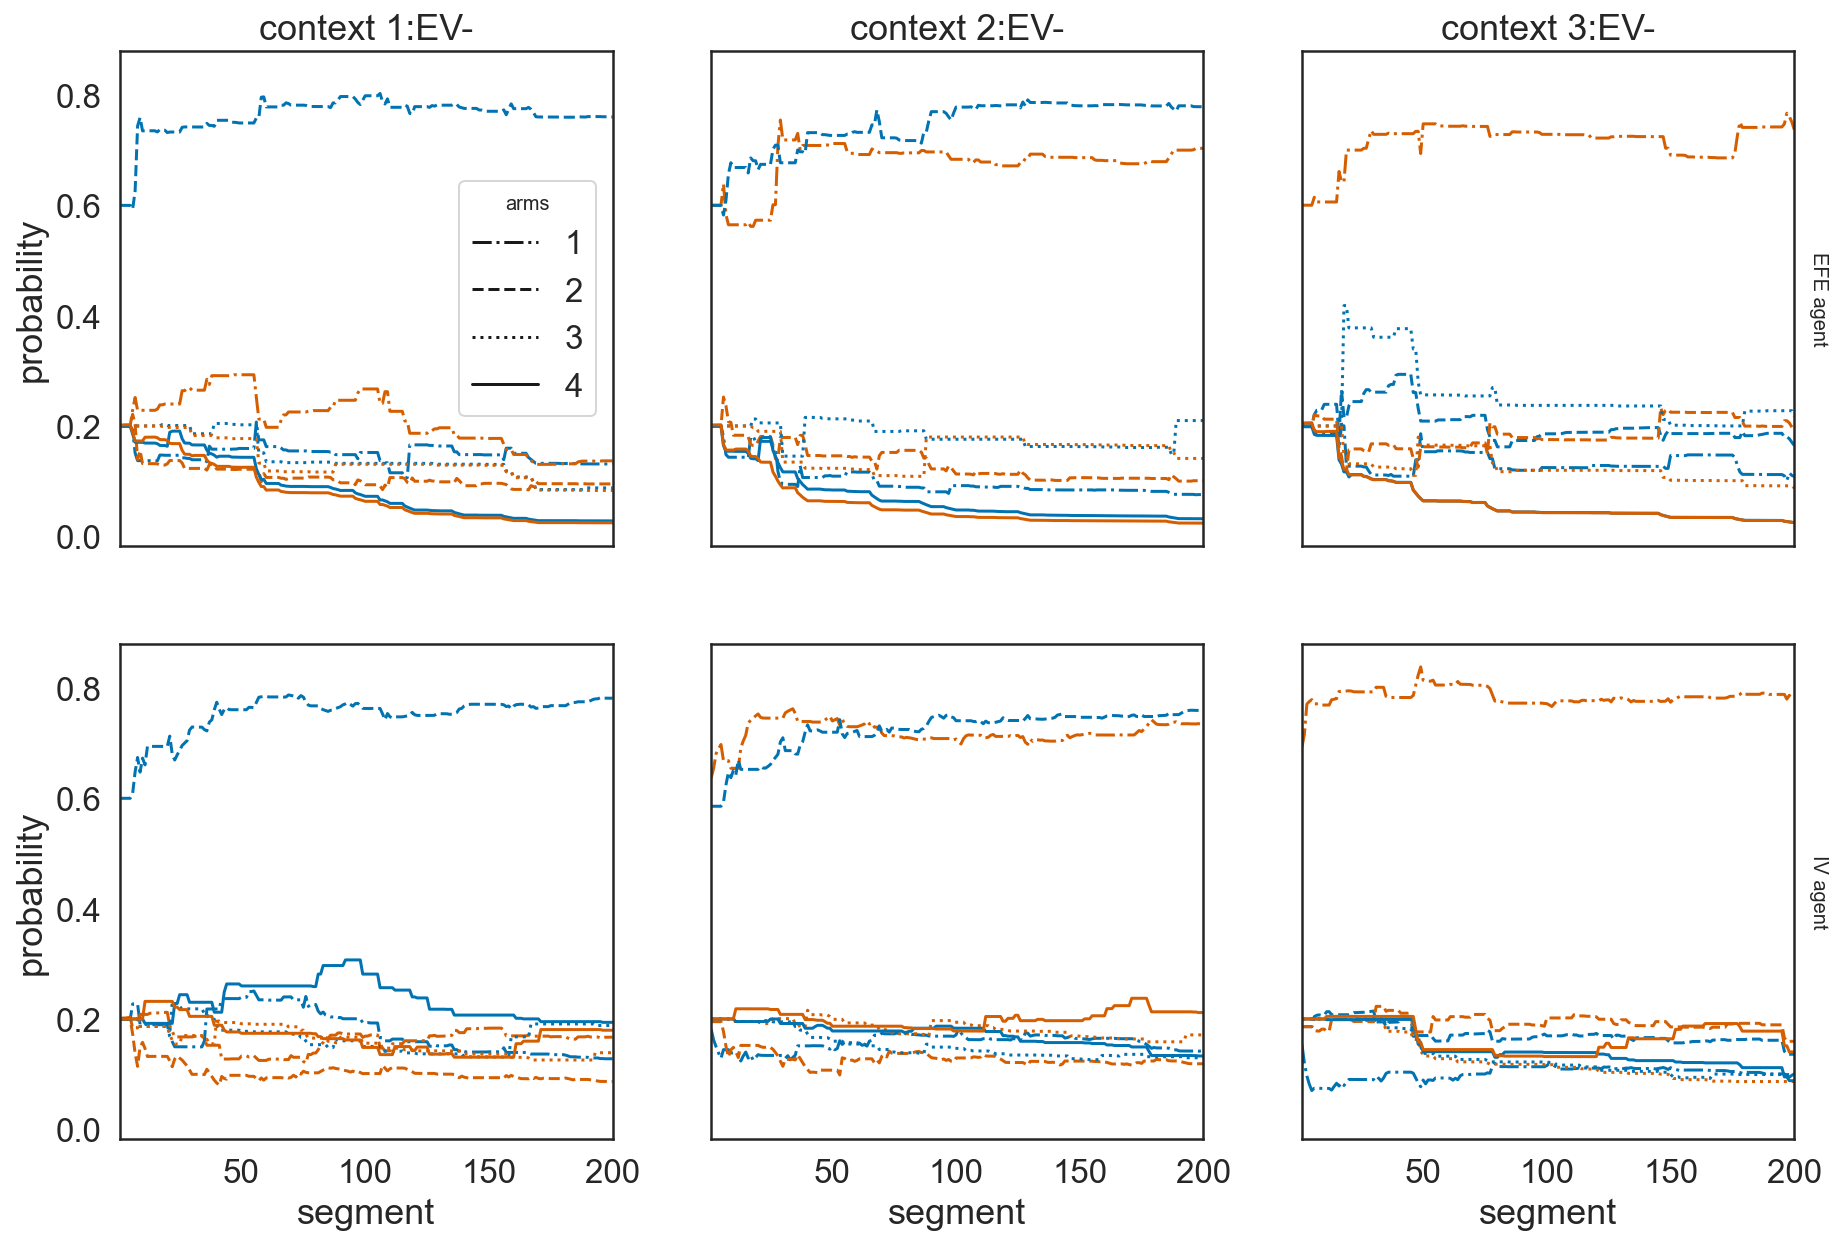

In [17]:
fig, axes = plt.subplots(2, 3, figsize=(15, 10), sharex=True, sharey=True)

for i,c in enumerate([0, 2, 4]):
    axes[0, i].plot(t, A1[:, -1, sub, c, 0, 1].numpy(), 'b-.');
    axes[0, i].plot(t, A1[:, -1, sub, c, 0, 2].numpy(), 'r-.');
    axes[0, i].plot(t, A1[:, -1, sub, c, 1, 1].numpy(), 'b--');
    axes[0, i].plot(t, A1[:, -1, sub, c, 1, 2].numpy(), 'r--');
    axes[0, i].plot(t, A1[:, -1, sub, c, 2, 1].numpy(), 'b:');
    axes[0, i].plot(t, A1[:, -1, sub, c, 2, 2].numpy(), 'r:');
    axes[0, i].plot(t, A1[:, -1, sub, c, 3, 1].numpy(), 'b');
    axes[0, i].plot(t, A1[:, -1, sub, c, 3, 2].numpy(), 'r');
    axes[0, i].set_title('context {}:EV-'.format(i+1));
    
    a = torch.stack(iv_agent.a)[1:].reshape(blocks, trials, nsub, 6, 4, nf)
    A = a/a.sum(-1, keepdim=True)

    axes[1, i].plot(t, A2[:, -1, sub, c, 0, 1].numpy(), 'b-.');
    axes[1, i].plot(t, A2[:, -1, sub, c, 0, 2].numpy(), 'r-.');
    axes[1, i].plot(t, A2[:, -1, sub, c, 1, 1].numpy(), 'b--');
    axes[1, i].plot(t, A2[:, -1, sub, c, 1, 2].numpy(), 'r--');
    axes[1, i].plot(t, A2[:, -1, sub, c, 2, 1].numpy(), 'b:');
    axes[1, i].plot(t, A2[:, -1, sub, c, 2, 2].numpy(), 'r:');
    axes[1, i].plot(t, A2[:, -1, sub, c, 3, 1].numpy(), 'b');
    axes[1, i].plot(t, A2[:, -1, sub, c, 3, 2].numpy(), 'r');

axes[0, 0].legend(handles=styles, title='arms');
axes[-1, -1].set_xlim([1, blocks]);
axes[-1, 0].set_xlabel('segment');
axes[-1, -2].set_xlabel('segment');
axes[-1, -1].set_xlabel('segment');

axes[0, 0].set_ylabel('probability');
axes[1, 0].set_ylabel('probability');

axes[0, -1].text(1.05, .5, 'EFE agent', 
                 horizontalalignment='center',
                 verticalalignment='center',
                 rotation=-90,
                 transform=axes[0, -1].transAxes );

axes[1, -1].text(1.05, .5, 'IV agent', 
                 horizontalalignment='center',
                 verticalalignment='center',
                 rotation=-90,
                 transform=axes[1, -1].transAxes );